In [43]:
import csv
import rasterio
import pandas as pd
from numba import njit
#import folium
import numpy as np
import richdem as rd
#import geopandas as gpd
import matplotlib.pyplot as plt
#from shapely.geometry import box
from rasterio.mask import mask
from rasterio.features import rasterize
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist
from ipywidgets import interact, widgets
from matplotlib.colors import Normalize, PowerNorm

In [2]:
def load_dem(filename):
    """Load DEM data from a file and return the data array, transform, and CRS."""
    with rasterio.open(filename) as src:
        dem = src.read(1).astype(float)  # Read DEM data as float
        transform = src.transform  # Get affine transform
        crs = src.crs  # Get coordinate reference system (CRS)
    return dem, transform, crs

def replace_no_data(dem, no_data_value):
    """Replace no-data values in DEM with NaN."""
    dem[dem == no_data_value] = np.nan
    return dem

def interpolate_nans(dem):
    """Interpolate missing data (NaNs) in the DEM."""
    x, y = np.indices(dem.shape)
    valid_mask = ~np.isnan(dem)
    dem_interpolated = griddata(
        (x[valid_mask], y[valid_mask]),  # Valid points
        dem[valid_mask],                 # Valid values
        (x, y),                          # All points
        method='nearest'                 # Interpolation method
    )
    return dem_interpolated

def calculate_slope(dem):
    """Calculate slope from the DEM using richdem."""
    dem_rd = rd.rdarray(dem, no_data=np.nan)
    slope = rd.TerrainAttribute(dem_rd, attrib='slope_riserun')
    return slope

def calculate_flow_accumulation(dem):
    """Calculate flow accumulation from the DEM using richdem."""
    dem_rd = rd.rdarray(dem, no_data=np.nan)
    flow_accumulation = rd.FlowAccumulation(dem_rd, method='D8')
    return flow_accumulation

def load_soil_texture(shapefile, dem_crs):
    """Load soil texture data from a shapefile and reproject it to the DEM's CRS."""
    soil_texture = gpd.read_file(shapefile)
    soil_texture = soil_texture.to_crs(dem_crs)
    return soil_texture

def clip_raster_with_geometry(raster, transform, geometry):
    """Clip the raster using a given geometry."""
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, [geometry], crop=True)
    out_image = out_image[0]  # Extract the first band
    return out_image, out_transform

#def get_overlapping_extent(dem, dem_transform, soil_texture):
#    """Get the overlapping extent between the DEM and soil texture data."""
#    dem_bounds = rasterio.transform.array_bounds(dem.shape[0], dem.shape[1], dem_transform)
#    dem_polygon = box(*dem_bounds)
#    soil_texture_bounds = soil_texture.total_bounds
#    soil_texture_polygon = box(*soil_texture_bounds)
#    overlap_polygon = dem_polygon.intersection(soil_texture_polygon)
#    return overlap_polygon

def categorize_slope(slope, n_intervals):
    """Categorize slope into specified number of intervals."""
    slope_min, slope_max = np.nanmin(slope), np.nanmax(slope)
    bins = np.linspace(slope_min, slope_max, n_intervals + 1)
    slope_categories = np.digitize(slope, bins) - 1  # Categories start at 1, so subtract 1
    return slope_categories

def rasterize_soil_texture(soil_texture, dem_shape, dem_transform, n_intervals):
    """Rasterize soil texture to match the DEM and categorize it."""
    texture_bins = {
        'S': 1, 'LS': 2, 'SL': 3, 'L': 4, 'SCL': 5,
        'CL': 6, 'CN': 7, 'CC': 8, 'X': 9
    }
    soil_texture = soil_texture.copy()  # Ensure a copy of the DataFrame
    soil_texture.loc[:, 'texture_category'] = soil_texture['SOIL_TEXT'].map(texture_bins)
    shapes = ((geom, value) for geom, value in zip(soil_texture.geometry, soil_texture['texture_category']))
    rasterized_texture = rasterize(shapes, out_shape=dem_shape, transform=dem_transform, fill=np.nan)
    
    # Create texture intervals
    texture_min, texture_max = 1, len(texture_bins)
    bins = np.linspace(texture_min, texture_max, n_intervals + 1)
    texture_categories = np.digitize(rasterized_texture, bins) - 1  # Bins start at 1, so subtract 1
    return texture_categories

def lhcube_sampling(N, nrep, M):
    """Perform Latin Hypercube Sampling (LHS)."""
    d = 0
    for k in range(nrep):
        Xk = np.zeros((N, M))
        ran = np.random.random((N, M))
        for i in range(M):
            idx = np.random.choice(np.arange(1, N + 1, 1), size=(N,), replace=False)
            Xk[:, i] = (idx - ran[:, i]) / N
        dk = np.min(pdist(Xk, metric='euclidean'))
        if dk > d:
            X = Xk
            d = dk
    return X, d

### Inputs

In [3]:
dem_file = 'inputs/catchment_dem.tif'

### Computation

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


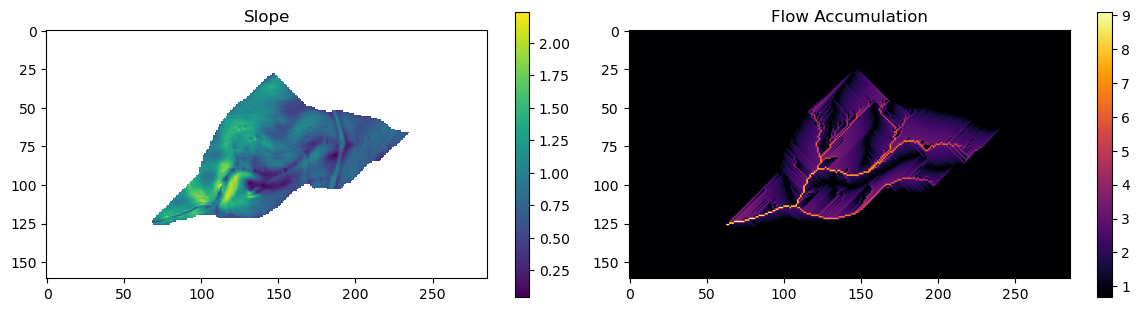

In [4]:
"""Main function to execute the workflow."""
dem, transform, crs = load_dem(dem_file)

# Handle no-data values
#no_data_value = -340282306073709650000000000000000000000.0
#dem = replace_no_data(dem, no_data_value)

# Interpolate missing data
#dem = interpolate_nans(dem)

# Load soil texture data
#soil_texture = load_soil_texture(soil_texture_file, crs)

# Get the overlapping extent of DEM and soil texture
#overlap_extent = get_overlapping_extent(dem, transform, soil_texture)

# Clip DEM and soil texture
#dem_clipped, transform_clipped = clip_raster_with_geometry(dem_file, transform, overlap_extent)
#soil_texture_clipped = soil_texture.loc[soil_texture.intersects(overlap_extent)].copy()

# Calculate slope and flow accumulation
slope = calculate_slope(dem)
flow_accumulation = calculate_flow_accumulation(dem)

# Plot slope and flow accumulation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title('Slope')
slope_show = ax1.imshow(slope, cmap='viridis')
plt.colorbar(slope_show, ax=ax1, shrink=0.5)
    
ax2.set_title('Flow Accumulation')
flow_show = ax2.imshow(np.log1p(flow_accumulation), cmap='inferno')  
plt.colorbar(flow_show, ax=ax2, shrink=0.5)
    
plt.tight_layout()
plt.show()

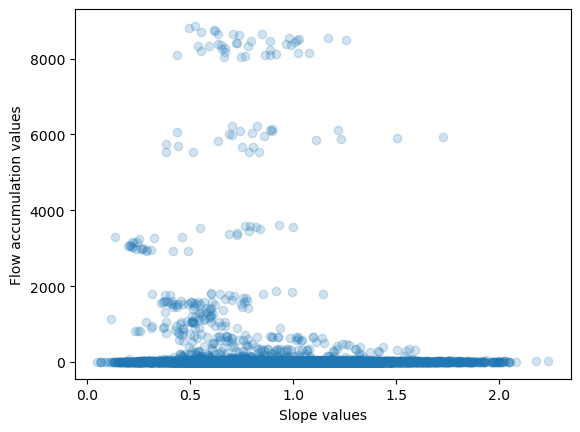

In [51]:
# Flatten arrays for LHS
slope_flat = slope.flatten()
flow_accumulation_flat = flow_accumulation.flatten()
#soil_texture_flat = soil_texture_categories.flatten()

# Remove NaNs
valid_mask = ~np.isnan(slope_flat) & ~np.isnan(flow_accumulation_flat)
slope_flat = slope_flat[valid_mask]
flow_accumulation_flat = flow_accumulation_flat[valid_mask]
#soil_texture_flat = soil_texture_flat[valid_mask]

# Scatter plot of the combinations of slope and flow accumulation that are found in the study area
plt.xlabel('Slope values')
plt.ylabel('Flow accumulation values')
plt.scatter(slope_flat,flow_accumulation_flat,alpha = 0.2)
plt.show()

## Function to count the number of sampled data that is actually present in the data (real sampled data)

In [46]:
def count_common_pairs(array1, array2):
    """Counts the number of 2-value pairs that appear in both arrays using a for loop.
    
    Args:
    array1: A 2D array with 2 columns.
    array2: A 2D array with 2 columns.
    
    Returns:
    The number of common 2-value pairs.
    """
    
    # Initialize a counter to keep track of the number of common pairs
    count = 0
    
    # Iterate over each pair in the first array
    for pair1 in array1:
        # Iterate over each pair in the second array
        for pair2 in array2:
            # Convert both pairs to tuples and compare them
            if tuple(pair1) == tuple(pair2):
                # If a match is found, increment the counter
                count += 1
                # Break the inner loop to avoid counting the same pair multiple times
                break
    
    # Return the total count of common pairs
    return count

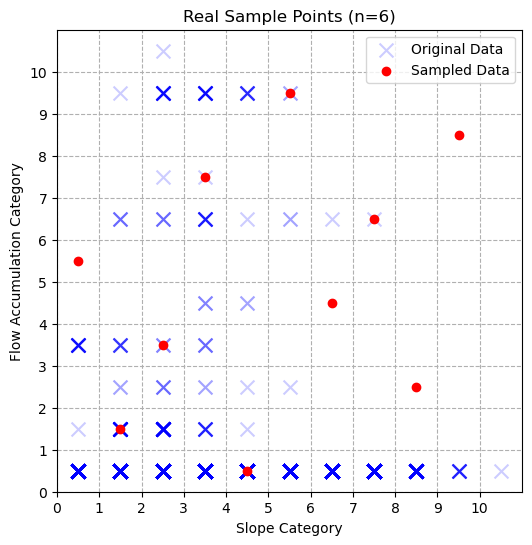

In [75]:
# Number of samples for categorization
n_samples = 10

# Categorize slope into bins
slope_categories = categorize_slope(slope_flat, n_samples)
flow_accumulation_categories = categorize_slope(flow_accumulation_flat, n_samples)

# Uncomment and modify this line if soil texture categorization is required
# Rasterize soil texture to match DEM and categorize
# soil_texture_categories = rasterize_soil_texture(soil_texture_clipped, dem_clipped.shape, transform_clipped, n_samples)

# Stack the slope and flow accumulation categories into a 2D array
data = np.vstack((slope_categories, flow_accumulation_categories)).T

# Latin Hypercube Sampling (LHS) parameters
N = n_samples         # Number of samples
M = data.shape[1]     # Number of variables (dimensions), in this case, 2 (slope and flow accumulation)
nrep1 = 100           # Number of repetitions to find optimal sampling within LHS
nrep2 = 10         # Number of repetitions to find the maximum number of real sampled data
n_real_samples = 0    # Initialize the count of real sampled data

# Loop to find the optimal sample points using LHS
for k in range(nrep2):
    # Perform Latin Hypercube Sampling
    X, d = lhcube_sampling(N, nrep1, M)
    
    # Initialize an array to store sampled data points
    sampled_data = np.zeros_like(X)
    
    # Map LHS sampled points to actual data bins
    for i in range(M):
        # Create bins for each variable
        bins = np.linspace(np.min(data[:, i]), np.max(data[:, i]), N + 1)
        for j in range(N):
            # Map each LHS point to the center of the corresponding bin
            sampled_data[j, i] = (bins[int(X[j, i] * N)] + bins[int(X[j, i] * N) + 1]) / 2
    
    # Check if the current sampled data has more real samples than the previous best
    if count_common_pairs(sampled_data, data + 0.5) > n_real_samples:
        real_sampled_data = sampled_data
        n_real_samples = count_common_pairs(sampled_data, data + 0.5)

# Plot optimized sample points
plt.figure(figsize=(6, 6))
plt.title(f'Real Sample Points (n={n_real_samples})')
# Plot the original data points (blue 'x')
plt.scatter(data[:, 0] + 0.5, data[:, 1] + 0.5, marker='x', c='blue', s=100, label='Original Data',alpha = 0.2)
# Plot the sampled data points (red dots)
plt.scatter(real_sampled_data[:, 0], real_sampled_data[:, 1], c='red', label='Sampled Data')
# Labeling the axes
plt.xlabel('Slope Category')
plt.ylabel('Flow Accumulation Category')
# Adding a grid for better visualization
plt.grid(True, linestyle='--')
# Add grid lines to match the categorization bins
bins_slope = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), n_samples + 1)
bins_flow_accumulation = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), n_samples + 1)
plt.xticks(bins_slope)
plt.yticks(bins_flow_accumulation)
# Add a legend to the plot
plt.legend()
# Show the plot
plt.show()
